# 玻尔兹曼财富模型

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pylab as plt
plt.style.use('ggplot')
# 设置matplotlib显示中文
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# Mesa相关库
from mesa.model import Model
from mesa.time import RandomActivation
from mesa.agent import Agent
from mesa.datacollection import DataCollector

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = len(model.agents)
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B



class WealthModel(Model):
    """
    模拟财富分布的环境类，继承自 Model 类。
    """

    def __init__(self):
        """
        初始化 WealthEnv 环境。
        调用父类的初始化方法，并创建一个随机激活调度器（RandomActivation）。
        调度器每个时间步随机选择代理并激活它们，从而打乱了激活的顺序。例如有四个Agent，可能激活顺序是1,3,2,4
        """
        super().__init__()
        self.schedule = RandomActivation(self)  # 创建一个随机激活调度器，用于管理代理的激活顺序
        self.datacollector = DataCollector(model_reporters={"gini":compute_gini},agent_reporters={"Wealth": "wealth"})

    def step(self) -> None:
        """
        进行一步模拟。调用调度器的 step 方法，激活所有代理进行一步操作。
        """
        self.datacollector.collect(self)
        self.schedule.step()  # 调用调度器的 step 方法，激活所有代理进行一步操作

    def add_agents(self, agents: list[Agent]):
        """
        添加代理到环境中。

        参数:
        agents (list[Agent]): 要添加的代理列表。
        """
        for agent in agents:
            self.schedule.add(agent)  # 将每个代理添加到调度器中



In [3]:
class WealthAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.schedule.agents)
            other_agent.wealth += 1
            self.wealth -= 1

In [88]:
from tqdm import tqdm
steps = 200

env = WealthModel()
agents = [WealthAgent(i, env) for i in range(1000)]
env.add_agents(agents)

for i in tqdm(range(steps)):
    env.step()

100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


In [90]:
df=env.datacollector.get_agent_vars_dataframe()
df

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
199  951           0
     840           4
     813           0
     267           0
     391           1

[200000 rows x 1 columns]

In [91]:
last_wealth=df.xs(steps-1,level="Step") # 多级索引的提取方法，xs指定获取哪个层级下，为指定值的行
last_wealth

,Wealth
AgentID,
147,0
190,0
484,2
350,2
723,1
...,...
951,0
840,4
813,0


[Text(0.5, 1.0, '最终的财富分布'), Text(0.5, 0, '财富量')]

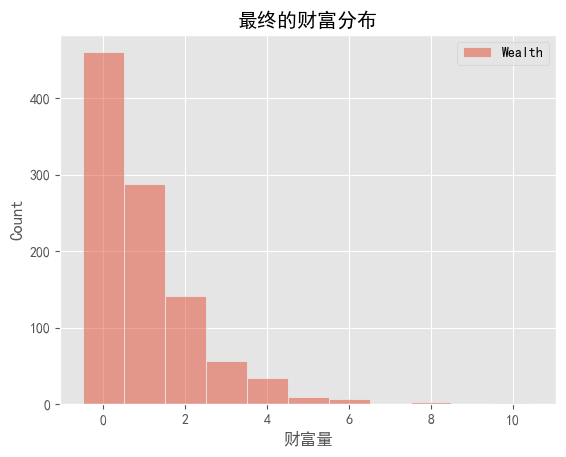

In [92]:

ax=sns.histplot(last_wealth, discrete=True)
ax.set(title="最终的财富分布",xlabel="财富量")


In [93]:
model_df=env.datacollector.get_model_vars_dataframe()
model_df

,gini
0,0.000000
1,0.527168
2,0.562730
3,0.594488
4,0.587262
...,...
195,0.636086
196,0.630780
197,0.625734
198,0.629146


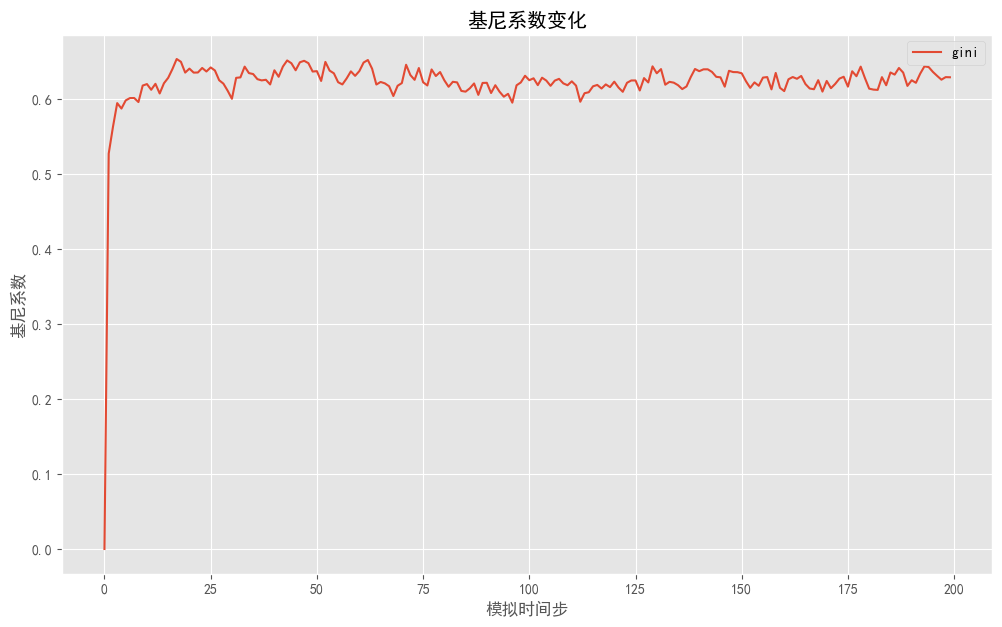

In [98]:
plt.figure(figsize=(12,7))
ax=sns.lineplot(model_df)
ax.set(title='基尼系数变化',ylabel="基尼系数",xlabel="模拟时间步");

## 富二代模型

In [37]:
class WealthAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 50

    def step(self):
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.schedule.agents)
            if type(other_agent) == RichSecondAgent:
                if self.wealth >= 2:
                    self.wealth -= 2
                    other_agent.wealth += 2
                    return
            other_agent.wealth += 1
            self.wealth -= 1


class RichSecondAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 250

    def step(self):
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.schedule.agents)
            other_agent.wealth += 2
            self.wealth -= 2

In [38]:
from tqdm import tqdm
steps = 5000

env = WealthModel()
agents = [WealthAgent(i, env) for i in range(280)]
agents+=[RichSecondAgent(i,env)  for i in range(280,300)]
env.add_agents(agents)

for i in tqdm(range(steps)):
    env.step()

100%|██████████| 5000/5000 [01:37<00:00, 51.52it/s]


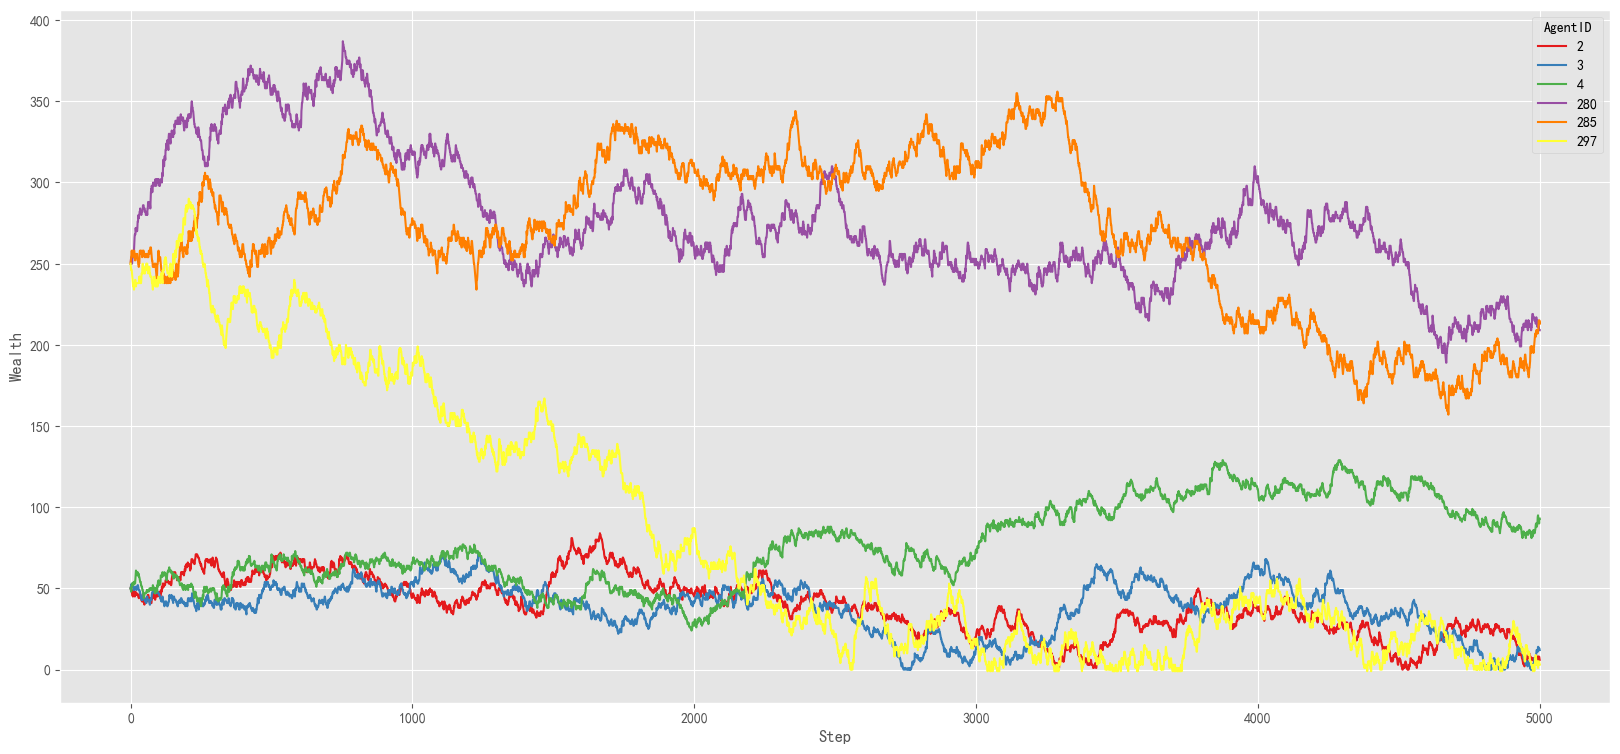

In [44]:
agent_df=env.datacollector.get_agent_vars_dataframe()
wealths=agent_df[agent_df.index.get_level_values("AgentID").isin([2,3,4,280,285,297])]
plt.figure(figsize=(20,9))
sns.lineplot(wealths,hue="AgentID",x="Step",y="Wealth",palette="Set1");